# ⚙️ Normalization of Breast Cancer Single-Cell Data

We apply three normalization strategies:
- Shifted Log Normalization
- Scran Size Factor Normalization
- Analytic Pearson Residuals Normalization


In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext rpy2.ipython


# 📥 Load the QC-filtered data
adata = sc.read("../../data/processed/breast_cancer_qc_filtered.h5ad")

print(f"✅ Loaded QC-filtered AnnData object: {adata.shape}")


✅ Loaded QC-filtered AnnData object: (34945, 47096)


In [2]:
'''
# Normalize total counts and log-transform
scaled_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scaled_counts["X"], copy=True)

# Plot total counts before and after
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.X.sum(1), bins=50, ax=axes[0])
axes[0].set_title("Original Total Counts")
sns.histplot(adata.layers["log1p_norm"].sum(1), bins=50, ax=axes[1])
axes[1].set_title("Shifted Log Normalized")
plt.show()
'''

'\n# Normalize total counts and log-transform\nscaled_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)\nadata.layers["log1p_norm"] = sc.pp.log1p(scaled_counts["X"], copy=True)\n\n# Plot total counts before and after\nfig, axes = plt.subplots(1, 2, figsize=(10, 5))\nsns.histplot(adata.X.sum(1), bins=50, ax=axes[0])\naxes[0].set_title("Original Total Counts")\nsns.histplot(adata.layers["log1p_norm"].sum(1), bins=50, ax=axes[1])\naxes[1].set_title("Shifted Log Normalized")\nplt.show()\n'

## 🔹 Scran Size Factor Normalization

We estimate cell-specific size factors using the Scran algorithm, adjusting for sequencing depth variation.


In [3]:
# Scran preprocessing: cluster cells
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="scran_groups")


/tmp/ipykernel_1640588/167235061.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added="scran_groups")


## 🔹 Run Scran in R to Compute Size Factors


In [4]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from scipy.sparse import issparse

pandas2ri.activate()

data_mat = adata.X.T

# If sparse, convert to dense
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo().toarray()
    else:
        data_mat = data_mat.tocsc().toarray()

# Now send to R
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["scran_groups"]


In [5]:
%%R -o size_factors
library(scran)
library(SingleCellExperiment)
library(BiocParallel)

size_factors = sizeFactors(
  computeSumFactors(
    SingleCellExperiment(list(counts=data_mat)),
    clusters=input_groups,
    min.mean=0.1,
    BPPARAM=MulticoreParam()
  )
)


R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowC


Error in get(as.character(FUN), mode = "function", envir = envir) : 
  object 'as.SimpleList' of mode 'function' was not found


RInterpreterError: Failed to parse and evaluate line 'library(scran)\nlibrary(SingleCellExperiment)\nlibrary(BiocParallel)\n\nsize_factors = sizeFactors(\n  computeSumFactors(\n    SingleCellExperiment(list(counts=data_mat)),\n    clusters=input_groups,\n    min.mean=0.1,\n    BPPARAM=MulticoreParam()\n  )\n)\n'.
R error message: 'Error in get(as.character(FUN), mode = "function", envir = envir) : \n  object \'as.SimpleList\' of mode \'function\' was not found'

/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)
/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)


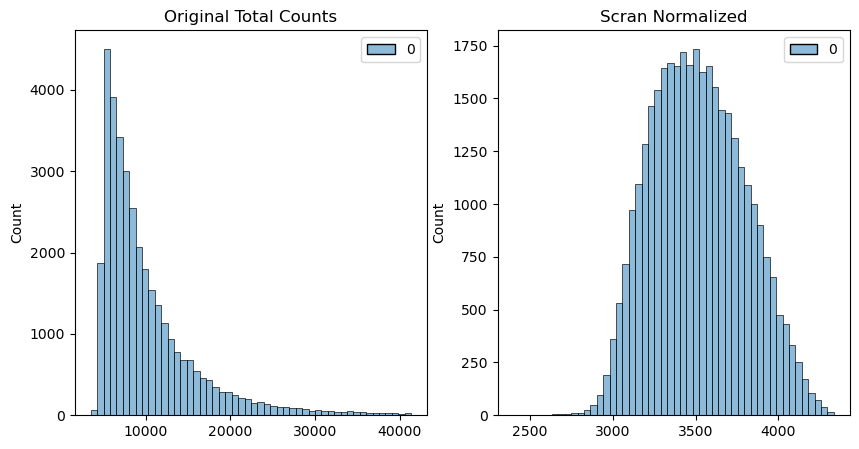

In [ ]:
# Apply scran normalization
adata.obs["size_factors"] = size_factors
scran_norm = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = np.log1p(scran_norm)

# Plot Scran normalized
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.X.sum(1), bins=50, ax=axes[0])
axes[0].set_title("Original Total Counts")
sns.histplot(adata.layers["scran_normalization"].sum(1), bins=50, ax=axes[1])
axes[1].set_title("Scran Normalized")
plt.show()


In [ ]:
from scipy.sparse import issparse

# Convert to CSR if needed
if issparse(adata.layers["scran_normalization"]):
    adata.layers["scran_normalization"] = adata.layers["scran_normalization"].tocsr()

# Now safely save
adata.write("../../data/processed/breast_cancer_normalized_all_layers.h5ad")
print("✅ Saved all normalized layers to 'breast_cancer_normalized_all_layers.h5ad'")


## 🔹 Analytic Pearson Residuals Normalization

We apply analytic Pearson residuals, which stabilize variance and preserve biological heterogeneity.


/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:72: RuntimeWarning: invalid value encountered in divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)
/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)
/home/guests3/gba/.conda/envs/tese-env/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarni

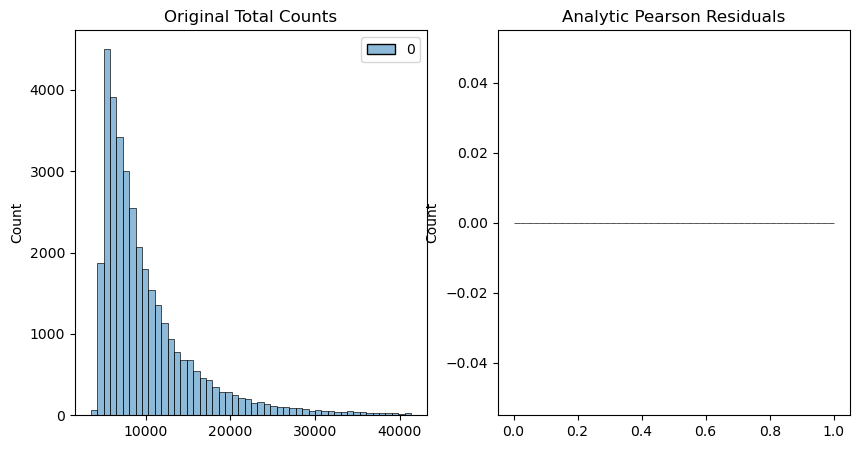

In [ ]:
'''
# Compute Analytic Pearson Residuals
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["pearson_residuals"] = analytic_pearson["X"]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.X.sum(1), bins=50, ax=axes[0])
axes[0].set_title("Original Total Counts")
sns.histplot(adata.layers["pearson_residuals"].sum(1), bins=50, ax=axes[1])
axes[1].set_title("Analytic Pearson Residuals")
plt.show()
'''


## 💾 Save All Normalized Data Layers


In [ ]:
'''
from scipy.sparse import issparse

# Convert to CSR if needed
if issparse(adata.layers["scran_normalization"]):
    adata.layers["scran_normalization"] = adata.layers["scran_normalization"].tocsr()

# Now safely save
adata.write("../../data/breast_cancer_normalized_all_layers.h5ad")
print("✅ Saved all normalized layers to 'breast_cancer_normalized_all_layers.h5ad'")
'''

✅ Saved all normalized layers to 'breast_cancer_normalized_all_layers.h5ad'
